In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Иерархия алгоритмов:
![title](img/classes.jpg)

In [2]:
from sklearn.datasets import make_classification

datasets = {}
datasets['X_wide'], datasets['y_wide'] = make_classification(
    n_samples=100, n_features=2000,
    n_informative=50, n_redundant=0,
    shuffle=False, random_state=42,
    n_classes=5)

datasets['X_mid'], datasets['y_mid'] = make_classification(
    n_samples=800, n_features=800,
    n_informative=50, n_redundant=0,
    shuffle=False, random_state=42,
    n_classes=5)

datasets['X_tall'], datasets['y_tall'] = make_classification(
    n_samples=2000, n_features=100,
    n_informative=10, n_redundant=0,
    shuffle=False, random_state=42,
    n_classes=5)

datasets['X_clustered'], datasets['y_clustered'] = make_classification(
    n_samples=500, n_features=50,
    n_informative=8, n_redundant=0,
    shuffle=False, random_state=42,
    n_classes=5, n_clusters_per_class=1)

from sklearn.preprocessing import KBinsDiscretizer
datasets_discretized = {}
est = KBinsDiscretizer(n_bins=20, encode='ordinal')
for k, v in datasets.items():
    if k.startswith('X'):
        datasets_discretized[k] = est.fit_transform(v)
    else:
        datasets_discretized[k] = v

In [17]:
from ITMO_FS.filters.univariate import UnivariateFilter
from ITMO_FS.filters.univariate.measures import f_ratio_measure
f = UnivariateFilter(f_ratio_measure, ("K best", 10))
X, y = datasets['X_clustered'], datasets['y_clustered']
X_tr = f.fit_transform(X, y)
print(X_tr)
print("Shape: %s ----> %s" % (X.shape, X_tr.shape))
print(f.selected_features_)

[[-1.70668357  1.78643355 -3.68359706 ...  0.53050257  0.53504519
  -0.71670883]
 [-2.81445618 -0.7109764  -2.37447969 ...  0.49091535 -0.21800281
  -1.09764465]
 [-2.4573421   1.05273718 -1.69359949 ... -0.29152131  1.2759773
  -1.37745741]
 ...
 [ 1.31613119  1.42530803 -0.54350685 ... -0.58089393  0.00901122
   0.5965405 ]
 [-2.10545301 -0.89867634  2.08439813 ...  0.04125804 -0.19896326
  -0.84588299]
 [ 1.1035561   2.00816396  0.83761519 ... -0.82787821  1.62251799
  -0.11674565]]
Shape: (500, 50) ----> (500, 10)
[ 6  2  7  4  0  1  3 33 31 41]


In [3]:
exec_times = {}
scores = {}
bases = {}
labels = {}
exec_times_d = {}
scores_d = {}
bases_d = {}
labels_d = {}
for ds in ['wide', 'mid', 'tall', 'clustered']:
    exec_times[ds] = []
    scores[ds] = []
    bases[ds] = None
    labels[ds] = []
    exec_times_d[ds] = []
    scores_d[ds] = []
    bases_d[ds] = None
    labels_d[ds] = []

def run_model(model, discretized, model_name,
              d=['wide', 'mid', 'tall', 'clustered'],
              estimator=LogisticRegression(),
              cv=10, measure='f1_macro'):
    if discretized:
        exec_times_source = exec_times_d
        scores_source = scores_d
        labels_source = labels_d
        dataset_source = datasets_discretized
        bases_source = bases_d
    else:
        exec_times_source = exec_times
        scores_source = scores
        labels_source = labels
        dataset_source = datasets
        bases_source = bases
    for ds in d:
        X = dataset_source['X_' + ds]
        y = dataset_source['y_' + ds]
        if bases_source[ds] is None:
            base_score = cross_val_score(
                estimator, X, y, cv=cv,
                scoring=measure).mean()
            bases_source[ds] = base_score
        else:
            base_score = bases_source[ds]
        print("Base score for %s classification: %.3f" % (ds, base_score))
        print("Running the model on %s classification:" % ds)
        time, score = run_model_ds(model, X, y, estimator, cv, measure)
        print("Results for model %s: execution time = %.5f s, "
          "resulting measure = %.3f" % (model_name, time, score))
        exec_times_source[ds].append(time)
        scores_source[ds].append(score)
        labels_source[ds].append(model_name)

def run_model_ds(model, X, y, estimator, cv, measure):
    t = %timeit -q -n 1 -r 1 -o model.fit(X, y)
    X_ = X[:, model.selected_features_]
    print("Selected %d features out of %d: %s"
          % (model.selected_features_.shape[0], X.shape[1],
             model.selected_features_))
    score = cross_val_score(
        estimator, X_, y, cv=cv,
        scoring=measure).mean()
    return t.best, score

In [4]:
from matplotlib import pyplot as plt
import mpld3


mpld3.enable_notebook()

def plot_results(ds, discretized):
    fig, ax = plt.subplots()
    ax.set_xlabel('Time')
    ax.set_ylabel('Score')
    if discretized:
        scores_source = scores_d
        exec_times_source = exec_times_d
        base_source = bases_d
        labels_source = labels_d
    else:
        scores_source = scores
        exec_times_source = exec_times
        base_source = bases
        labels_source = labels
    scatter = ax.scatter(
        exec_times_source[ds], scores_source[ds],
        c=np.random.random(size=len(scores_source[ds])))
    xmin, xmax = ax.get_xlim()
    ax.hlines(base_source[ds], xmin, xmax)

    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels_source[ds])
    mpld3.plugins.connect(fig, tooltip)

    plt.show()


## Фильтрующие алгоритмы
![title](img/filters.jpg)

In [18]:
from ITMO_FS.filters.univariate import select_k_best
from ITMO_FS.filters.univariate import UnivariateFilter
from ITMO_FS.filters.univariate import gini_index
f = UnivariateFilter(gini_index, select_k_best(10))
run_model(f, True, 'Univariate(Gini, 10)')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [1034  354 1669 1710 1618  544  442  848  242 1347]
Results for model Univariate(Gini, 10): execution time = 1.61508 s, resulting measure = 0.278
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [ 30   0  24   1 472 416  19 227  54  42]
Results for model Univariate(Gini, 10): execution time = 0.67682 s, resulting measure = 0.342
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [5 7 8 2 4 3 6 9 0 1]
Results for model Univariate(Gini, 10): execution time = 0.11734 s, resulting measure = 0.573
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 1  7  2  6  4  3  0 47 17 33]
Results for model Univariate(Gini, 10): execution time = 0.04276 s, resulting measure = 0.664


In [19]:
from ITMO_FS.filters.univariate import spearman_corr
f = UnivariateFilter(spearman_corr, select_k_best(10))
run_model(f, True, 'Univariate(Spearman, 10)')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [1122   20 1777   26   21  658  910  545 1677 1372]
Results for model Univariate(Spearman, 10): execution time = 0.15752 s, resulting measure = 0.246
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [  9 764  20 307 340  19 735 624 733 389]
Results for model Univariate(Spearman, 10): execution time = 0.11544 s, resulting measure = 0.237
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [ 6  3  4 10 92 83 72 35  0 42]
Results for model Univariate(Spearman, 10): execution time = 0.02743 s, resulting measure = 0.352
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 3  7  1  4 41 34 25 32 19 31]
Results for model Univariate(Spearman, 10): execution time = 0.00578 s, 

In [20]:
from ITMO_FS.filters.univariate import modified_t_score
f = UnivariateFilter(modified_t_score, select_k_best(10))
run_model(f, False, 'Univariate(TScore, 10)')

Base score for wide classification: 0.280
Running the model on wide classification:
Selected 10 features out of 2000: [1779 1762  850   26  158  658  141 1530 1090  508]
Results for model Univariate(TScore, 10): execution time = 0.39288 s, resulting measure = 0.325
Base score for mid classification: 0.410
Running the model on mid classification:
Selected 10 features out of 800: [ 1  0 18 32  6 20 44 42 24 49]
Results for model Univariate(TScore, 10): execution time = 0.13798 s, resulting measure = 0.352
Base score for tall classification: 0.532
Running the model on tall classification:
Selected 10 features out of 100: [ 6  7  2  3  8  4  5  0 30 10]
Results for model Univariate(TScore, 10): execution time = 0.02495 s, resulting measure = 0.548
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 10 features out of 50: [ 1  0  6  3 33 34 35 15 44 41]
Results for model Univariate(TScore, 10): execution time = 0.01182 s, resulting measure 

In [21]:
from ITMO_FS.filters.univariate import f_ratio_measure
f = UnivariateFilter(f_ratio_measure, select_k_best(10))
run_model(f, False, 'Univariate(FRatio, 10)')

Base score for wide classification: 0.280
Running the model on wide classification:
Selected 10 features out of 2000: [1090  364  158  923 1317 1762 1779   52   21  872]
Results for model Univariate(FRatio, 10): execution time = 0.85801 s, resulting measure = 0.495
Base score for mid classification: 0.410
Running the model on mid classification:
Selected 10 features out of 800: [30  0 24 42  1 35 29 36 18 44]
Results for model Univariate(FRatio, 10): execution time = 0.37049 s, resulting measure = 0.386
Base score for tall classification: 0.532
Running the model on tall classification:
Selected 10 features out of 100: [5 7 4 8 3 2 6 9 1 0]
Results for model Univariate(FRatio, 10): execution time = 0.04258 s, resulting measure = 0.577
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 10 features out of 50: [ 6  2  7  4  0  1  3 33 31 41]
Results for model Univariate(FRatio, 10): execution time = 0.02294 s, resulting measure = 0.682


In [5]:
from ITMO_FS.filters.univariate import SPEC
f = SPEC(10)
run_model(f, False, 'SPEC(10)')

Base score for wide classification: 0.280
Running the model on wide classification:
Selected 10 features out of 2000: [ 508 1090  923 1317  637 1829  158 1779 1972 1762]
Results for model SPEC(10): execution time = 2.66004 s, resulting measure = 0.505
Base score for mid classification: 0.410
Running the model on mid classification:
Selected 10 features out of 800: [ 0 19 30  1 31 23 42  5 35 44]
Results for model SPEC(10): execution time = 10.83772 s, resulting measure = 0.405
Base score for tall classification: 0.532
Running the model on tall classification:
Selected 10 features out of 100: [5 2 4 7 9 8 3 1 6 0]
Results for model SPEC(10): execution time = 15.76174 s, resulting measure = 0.577
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 10 features out of 50: [ 1  5  2  6  3  7  4  0 33 31]
Results for model SPEC(10): execution time = 1.09706 s, resulting measure = 0.691


In [6]:
from ITMO_FS.filters.multivariate import MultivariateFilter
from ITMO_FS.filters.multivariate import JMI
f = MultivariateFilter('JMI', 10)
run_model(f, True, 'Multivariate(JMI, 10)', ['tall', 'clustered'])

Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [5 4 2 7 8 3 9 6 0 1]
Results for model Multivariate(JMI, 10): execution time = 31.91054 s, resulting measure = 0.573
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 7  2  1  3  4  6  0 29 49  9]
Results for model Multivariate(JMI, 10): execution time = 2.89335 s, resulting measure = 0.649


In [7]:
from ITMO_FS.filters.multivariate import DISRWithMassive
f = DISRWithMassive(10)
run_model(f, True, 'DISR(10)', ['tall', 'clustered'])

Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [ 1  2  3  4  5  6  7  8  9 43]
Results for model DISR(10): execution time = 77.63904 s, resulting measure = 0.562
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 0  1  2  3  4  6  7 17 33 47]
Results for model DISR(10): execution time = 5.31564 s, resulting measure = 0.664


In [8]:
from ITMO_FS.filters.unsupervised import MCFS
f = MCFS(10, k=5, p=11)
run_model(f, True, 'MCFS(10)')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [ 850 1214 1360 1728  497  133 1470 1451 1829   24]
Results for model MCFS(10): execution time = 0.24492 s, resulting measure = 0.272
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [560 473  46 788 735 348 652 323 363 168]
Results for model MCFS(10): execution time = 9.49774 s, resulting measure = 0.219
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [ 5  8  7 14  3  2 76 31 78 72]
Results for model MCFS(10): execution time = 33.95299 s, resulting measure = 0.473
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 4  2 36 41  6 18 30 42  5 38]
Results for model MCFS(10): execution time = 2.04349 s, resulting measure = 0.359


## Алгоритмы-обертки
![title](img/wrappers.jpg)

In [9]:
from ITMO_FS.wrappers.deterministic import SequentialForwardSelection
wrapper = SequentialForwardSelection(LogisticRegression(), 10, 'f1_macro')
run_model(wrapper, False, 'SFS(10)', ['tall', 'clustered'])

Base score for tall classification: 0.532
Running the model on tall classification:
Selected 10 features out of 100: [ 5  1  2  7  8  3  6  4 54 10]
Results for model SFS(10): execution time = 44.15818 s, resulting measure = 0.571
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 10 features out of 50: [ 6  7  0  2  1 31 14  4  3 11]
Results for model SFS(10): execution time = 11.64748 s, resulting measure = 0.691


In [10]:
from ITMO_FS.wrappers.deterministic import AddDelWrapper
wrapper = AddDelWrapper(LogisticRegression(), 'f1_macro')
run_model(wrapper, False, 'AddDel', ['tall', 'clustered'])

Base score for tall classification: 0.532
Running the model on tall classification:
Selected 15 features out of 100: [ 5  1  2  7  8  3  6  4 54 10 13 62 14 61 46]
Results for model AddDel: execution time = 109.67129 s, resulting measure = 0.568
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 6 features out of 50: [ 6  7  0  2  1 31]
Results for model AddDel: execution time = 12.86947 s, resulting measure = 0.649


In [11]:
from ITMO_FS.wrappers.randomized import HillClimbingWrapper
wrapper = HillClimbingWrapper(LogisticRegression(), measure='f1_macro', seed=42)
run_model(wrapper, False, 'HillClimbing', ['tall', 'clustered'])

Base score for tall classification: 0.532
Running the model on tall classification:
Selected 47 features out of 100: [ 0  1  2  3  4  5  6  7  8  9 17 20 22 24 26 30 31 32 34 35 38 39 40 41
 43 44 49 52 55 58 62 64 68 71 72 73 74 75 76 77 78 83 86 87 93 94 96]
Results for model HillClimbing: execution time = 41.47179 s, resulting measure = 0.573
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 20 features out of 50: [ 0  1  2  3  4  6  7  8 14 22 24 29 30 31 33 35 37 39 42 43]
Results for model HillClimbing: execution time = 16.19479 s, resulting measure = 0.674


## Эмбеддеды
![title](img/embeddeds.jpg)

In [12]:
from ITMO_FS.embedded import MOS
from sklearn.linear_model import SGDClassifier
embedded = MOS(model=SGDClassifier(), weight_func=lambda model: np.square(model.coef_).sum(axis=0))
run_model(embedded, False, 'MOS')

Base score for wide classification: 0.280
Running the model on wide classification:
Selected 808 features out of 2000: [   0    1    2    3    4    5    7    8    9   11   12   13   14   15
   16   17   18   19   20   21   22   23   24   25   26   27   28   29
   30   31   32   33   34   35   36   37   38   39   40   41   42   43
   44   45   46   47   48   49   52   55   56   57   61   68   76   77
   81   82   83   84   87   90   91   92   94   95   96  108  109  110
  117  119  122  124  125  128  129  138  141  146  147  149  151  153
  154  160  161  163  165  171  173  174  176  182  185  190  191  192
  196  198  204  205  206  208  212  214  216  220  221  226  227  228
  231  232  233  240  241  248  249  251  255  257  258  259  260  262
  264  267  270  272  274  275  278  279  280  281  286  287  288  289
  295  296  297  298  299  302  303  307  308  309  310  311  316  317
  318  322  324  329  330  331  335  336  338  341  344  345  346  348
  349  350  355  356  358  36

## Гибриды
![title](img/hybrids.jpg)

In [14]:
from ITMO_FS.filters.univariate import UnivariateFilter
from ITMO_FS.filters.univariate.measures import gini_index
from ITMO_FS.hybrid import FilterWrapperHybrid
hybrid = FilterWrapperHybrid(UnivariateFilter(gini_index, ("K best", 100)),
                             SequentialForwardSelection(LogisticRegression(), 10, 'f1_macro'))
run_model(hybrid, True, 'FilterWrapper', ['wide', 'mid'])

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [1380  335 1626 1559 1669  728 1775  850   38 1618]
Results for model FilterWrapper: execution time = 57.44758 s, resulting measure = 0.404
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [  0  30   5  48 416  64  22 231 750 520]
Results for model FilterWrapper: execution time = 78.31047 s, resulting measure = 0.353


## Ансамбли на основе метрик
![title](img/measures.jpg)

In [22]:
from ITMO_FS.ensembles.measure_based import WeightBased
filters = [UnivariateFilter('GiniIndex'),
           UnivariateFilter('FechnerCorr'),
           UnivariateFilter('SpearmanCorr'),
           UnivariateFilter('PearsonCorr')]
ensemble = WeightBased(filters, ("K best", 10))
run_model(ensemble, True, 'WeightBased')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [1122  910   20 1372  545 1034  242 1688  233 1626]
Results for model WeightBased: execution time = 1.76691 s, resulting measure = 0.236
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [764 567   6 735 722 414  19   9  20 465]
Results for model WeightBased: execution time = 0.84735 s, resulting measure = 0.302
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [ 6  3  4  8  5  0 10 72 35 92]
Results for model WeightBased: execution time = 0.14191 s, resulting measure = 0.480
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 3  7  1  4  2  6 41 34 19 17]
Results for model WeightBased: execution time = 0.04552 s, resulting measure = 0.615


## Модельные ансамбли
![title](img/models.jpg)

In [15]:
from ITMO_FS.ensembles.model_based import BestSum
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
models = [SVC(kernel='linear'),
          LogisticRegression(),
          RidgeClassifier()]
ensemble = BestSum(models, ("K best", 10),
                   lambda model: np.square(model.coef_).sum(axis=0),
                   cv=10)
run_model(ensemble, False, 'BestSum')

Base score for wide classification: 0.280
Running the model on wide classification:
Selected 10 features out of 2000: [48 26 35 21 34  4 19 13 29 38]
Results for model BestSum: execution time = 1.40794 s, resulting measure = 0.308
Base score for mid classification: 0.410
Running the model on mid classification:
Selected 10 features out of 800: [ 56  85 105  44  42 722   0 601 725 434]
Results for model BestSum: execution time = 4.35793 s, resulting measure = 0.293
Base score for tall classification: 0.532
Running the model on tall classification:
Selected 10 features out of 100: [ 5  2  4  8  7  3  1  9 36  6]
Results for model BestSum: execution time = 31.37034 s, resulting measure = 0.558
Base score for clustered classification: 0.589
Running the model on clustered classification:
Selected 10 features out of 50: [ 6  4  2  7  1  5  0 25  3 26]
Results for model BestSum: execution time = 0.70753 s, resulting measure = 0.670


## Ансамбли на основе рейтингов
![title](img/rankings.jpg)

In [23]:
from ITMO_FS.ensembles.ranking_based import Mixed
ensemble = Mixed([gini_index, spearman_corr, modified_t_score, f_ratio_measure], 10)
run_model(ensemble, True, 'Mixed')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [1122 1034 1762  158 1779  364  354   20   26 1090]
Results for model Mixed: execution time = 2.77093 s, resulting measure = 0.452
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [  0   9  30   1 764  24  20  18  32 307]
Results for model Mixed: execution time = 1.24268 s, resulting measure = 0.329
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [ 5  6  2  7  3  8  4 10 92 83]
Results for model Mixed: execution time = 0.19472 s, resulting measure = 0.529
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 3  6  1  0  2  7  4 33 41 34]
Results for model Mixed: execution time = 0.09419 s, resulting measure = 0.647


In [16]:
from ITMO_FS.hybrid import Melif
filters = [UnivariateFilter('GiniIndex'),
           UnivariateFilter('FechnerCorr'),
           UnivariateFilter('SpearmanCorr'),
           UnivariateFilter('PearsonCorr')]
hybrid = Melif(LogisticRegression(), 'f1_macro', ("K best", 10), filters, delta=1)
run_model(hybrid, True, 'Melif')

Base score for wide classification: 0.132
Running the model on wide classification:
Selected 10 features out of 2000: [  52  287  972   19 1325  806   13  913 1617  483]
Results for model Melif: execution time = 6.74595 s, resulting measure = 0.304
Base score for mid classification: 0.299
Running the model on mid classification:
Selected 10 features out of 800: [ 30   0  24   1 472 416  19 227  54  42]
Results for model Melif: execution time = 9.99534 s, resulting measure = 0.342
Base score for tall classification: 0.521
Running the model on tall classification:
Selected 10 features out of 100: [5 6 4 3 8 7 2 9 0 1]
Results for model Melif: execution time = 12.18201 s, resulting measure = 0.573
Base score for clustered classification: 0.562
Running the model on clustered classification:
Selected 10 features out of 50: [ 2  1  6  0  7  4  3 47 33 17]
Results for model Melif: execution time = 7.10050 s, resulting measure = 0.664


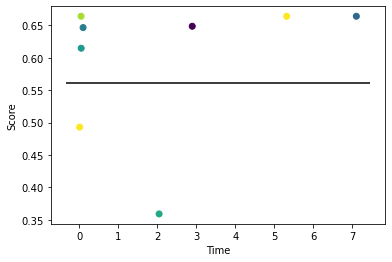

In [24]:
plot_results('clustered', True)

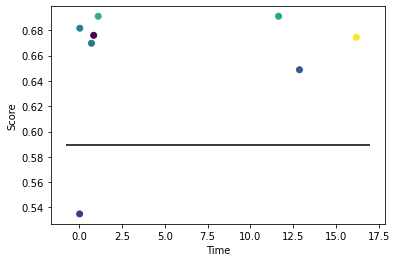

In [25]:
plot_results('clustered', False)

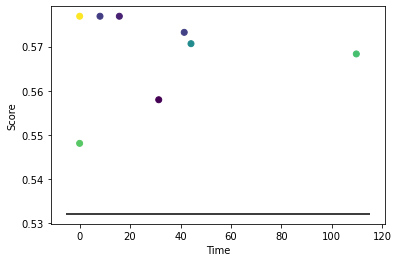

In [26]:
plot_results('tall', False)